In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.datasets import make_classification
import ipywidgets as widgets
from IPython.display import display, clear_output
# Other packages
pd.set_option('display.width', 2000)

In [2]:
df= pd.read_csv('/Users/puneethvishisthraavi/Documents/ML/ML_Project/Data/SVM-LR-NN.csv')

print("Raw Dataset Top Rows: Shows the first 5 rows to get a quick look at the data.")
print(df.head())
print("\nDataset Info: Displays column names, data types, and non-null counts to understand structure and missing values.")
df.info()

Raw Dataset Top Rows: Shows the first 5 rows to get a quick look at the data.
    wgt  gender  ed_lvl  income_q  employed  rural  account  savings  loans  mobile  ...  agri_sale_2  agri_sale_3  agri_sale_4  utilities_2  utilities_3  utilities_4  remittances_2  remittances_3  remittances_4  age_sqrt
0  0.33       0       3         3         1      0        1        0      0       0  ...        False        False         True         True        False        False          False          False           True     4.243
1  1.33       1       1         1         1      1        1        0      0       1  ...        False        False         True        False        False        False          False          False           True     6.403
2  1.46       1       1         2         0      1        1        0      1       0  ...        False        False         True         True        False        False          False          False           True     4.796
3  0.39       0       2         2 

In [3]:
y = df["account"]
wgt = df["wgt"]
X = df.drop(["account", "wgt"], axis=1)
scale_cols = ['age_sqrt', 'ed_lvl', 'income_q']

X_train, X_test, y_train, y_test, wgt_train, wgt_test = train_test_split(X, y, wgt, test_size = 0.25, random_state = 24, stratify = y)

scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

display(pd.DataFrame(X_train_scaled).sort_index(ascending=True))

,gender,ed_lvl,income_q,employed,rural,savings,loans,mobile,internet,wages_2,...,agri_sale_2,agri_sale_3,agri_sale_4,utilities_2,utilities_3,utilities_4,remittances_2,remittances_3,remittances_4,age_sqrt
1,1,0.0,0.00,1,1,0,0,1,1,False,...,False,False,True,False,False,False,False,False,True,0.522188
2,1,0.0,0.25,0,1,0,1,0,1,True,...,False,False,True,True,False,False,False,False,True,0.190506
3,0,0.5,0.25,1,0,0,0,0,1,False,...,False,False,True,False,False,True,False,False,True,0.051600
4,1,0.0,0.00,0,1,1,0,1,1,False,...,False,False,True,False,True,False,False,False,True,0.273065
6,1,0.5,0.25,0,0,0,0,0,0,False,...,False,False,True,True,False,False,False,False,True,0.630547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867,1,0.5,1.00,1,0,1,0,0,0,False,...,False,False,True,False,False,True,False,False,True,0.051600
2870,1,0.0,0.25,1,0,0,0,0,1,False,...,False,False,True,False,False,True,False,False,True,0.506089
2872,1,0.0,1.00,0,1,0,0,0,0,False,...,False,False,True,True,False,False,False,False,False,0.368215
2873,1,0.5,0.25,0,1,0,0,0,1,False,...,False,False,True,False,False,True,False,False,True,0.076367


In [4]:
kernels = ['linear', 'rbf', 'poly']
results = {}

for k in kernels:
    clf = SVC(kernel=k, probability=True, random_state=51)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    proba = clf.predict_proba(X_test_scaled)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc_val = auc(fpr, tpr)
    cv = cross_val_score(clf, X_train_scaled, y_train, cv=5).mean()
    results[k] = dict(model=clf, acc=acc, roc_auc=roc_auc_val, cv=cv)

summary = pd.DataFrame([{"Kernel": k, "Test Accuracy": v["acc"], "ROC-AUC": v["roc_auc"], "CV Mean": v["cv"]} for k, v in results.items()])
summary.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

,Kernel,Test Accuracy,ROC-AUC,CV Mean
0,linear,0.792768,0.765059,0.792769
1,poly,0.798331,0.719810,0.801574
2,rbf,0.795549,0.718292,0.795086


In [5]:
param_grid = [
    {"kernel": ["linear"], "C": [0.1, 1, 10], "class_weight": [None, "balanced"]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.1], "class_weight": [None, "balanced"]},
]

grid = GridSearchCV(SVC(probability=True, random_state=51), param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=0)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
best_kernel = best_model.get_params()["kernel"]

y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_best = auc(fpr, tpr)

print("Best params:", grid.best_params_)
print("Test accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Test ROC-AUC:", round(roc_auc_best, 4))

evaluation_results = {
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_best,
    "confusion_matrix": cm
}

Best params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Test accuracy: 0.5828
Test ROC-AUC: 0.779


In [6]:

print("Classification Report")
print(classification_report(y_test, y_pred,target_names=["No account", "have account"]))


Classification Report
              precision    recall  f1-score   support

  No account       0.31      0.86      0.46       149
have account       0.93      0.51      0.66       570

    accuracy                           0.58       719
   macro avg       0.62      0.68      0.56       719
weighted avg       0.80      0.58      0.62       719



In [7]:
# Confusion Matrix Heatmap + ROC
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Confusion Matrix", f"ROC Curve (AUC={roc_auc_best:.3f})"],
    specs=[[{"type": "heatmap"}, {"type": "xy"}]]
)

fig.add_trace(
    go.Heatmap(
        z=cm,
        x=['Predicted: No Account', 'Predicted: has an account'],
        y=['Actual: No Account', 'Actual: has an account'],
        colorscale='Blues',
        text=cm,
        texttemplate="%{text}",
        showscale=False
    ),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC'), row=1, col=2)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Random', line=dict(dash='dash')), row=1, col=2)
fig.update_layout(height=450, title=f"Best model: {best_kernel.upper()} SVM")
fig.show()

In [8]:
svm_model = best_model
try:
    n_total = len(svm_model.support_)
    per_class = svm_model.n_support_
    print(f"Total support vectors: {n_total}")
    print(f"Support vectors per class [0,1]: {per_class}")
except Exception as e:
    print("Support vector details not available for this kernel/config:", e)


Total support vectors: 1427
Support vectors per class [0,1]: [ 299 1128]


In [ ]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=51, scoring='roc_auc')
imp_df = pd.DataFrame({
    "feature": X_test_scaled.columns,
    "importance_mean": pi.importances_mean,
    "importance_std": pi.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)
imp_df


,feature,importance_mean,importance_std
0,utilities_4,0.104483,0.013590
1,transfers_4,0.059671,0.019887
2,wages_4,0.053813,0.013945
3,savings,0.037861,0.009276
4,wages_2,0.031696,0.006897
5,agri_sale_4,0.028787,0.008541
6,utilities_2,0.024128,0.010989
7,pension_4,0.023283,0.008314
8,internet,0.021539,0.006155
9,mobile,0.021441,0.005147


: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights for imbalance
class_weights_for_balance = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights_for_balance))

# Create combined sample weights: multiply original sample_weight by class_weight
# This applies both the survey weight and the class imbalance weight
class_weight_values = y_train.map(class_weight_dict)
combined_sample_weights = wgt_train * class_weight_values

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    sample_weight=combined_sample_weights, # Use the combined weights
    callbacks=[early_stopping],
    verbose=1
)

print("Neural Network training complete.")

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6725 - loss: 0.5616 - val_accuracy: 0.6227 - val_loss: 0.6830
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6814 - loss: 0.5707 - val_accuracy: 0.6227 - val_loss: 0.6951
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6969 - loss: 0.5361 - val_accuracy: 0.6296 - val_loss: 0.7033
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6933 - loss: 0.5420 - val_accuracy: 0.6157 - val_loss: 0.7156
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6942 - loss: 0.5252 - val_accuracy: 0.6343 - val_loss: 0.7136
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7085 - loss: 0.5322 - val_accuracy: 0.6296 - val_loss: 0.7262
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6935 - loss: 0.5206 - val_accuracy: 0.6273 - val_loss: 0.7173
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7142 - loss: 0.4865 - val_accuracy: 0.6343 - v

Test Loss: 0.6093
Test Accuracy: 0.6356
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.33      0.74      0.46       149
           1       0.90      0.61      0.73       570

    accuracy                           0.64       719
   macro avg       0.61      0.67      0.59       719
weighted avg       0.78      0.64      0.67       719

ROC-AUC Score: 0.7438


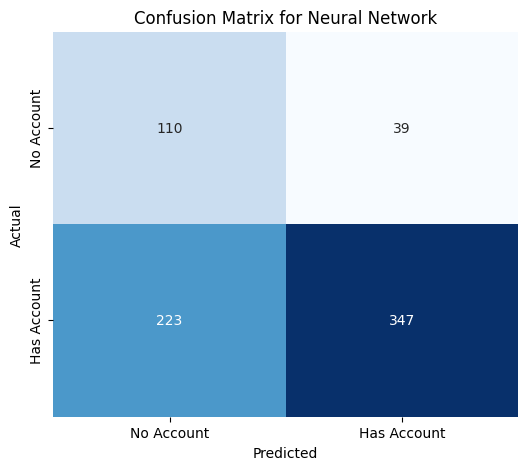

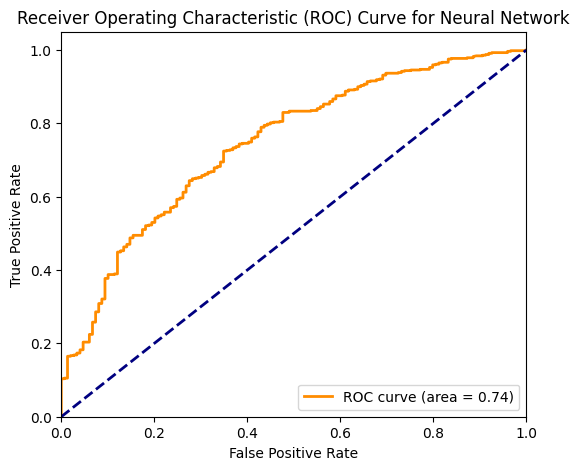

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, sample_weight=wgt_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_nn_proba = model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn))

roc_auc_nn = roc_auc_score(y_test, y_pred_nn_proba)
print(f"ROC-AUC Score: {roc_auc_nn:.4f}")

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Neural Network')
plt.legend(loc="lower right")
plt.show()

In [ ]:
n_features = X_train_scaled.shape[1]
X_train_cnn = X_train_scaled.values.reshape(X_train_scaled.shape[0], 1, n_features)
X_test_cnn = X_test_scaled.values.reshape(X_test_scaled.shape[0], 1, n_features)

print(f"Original X_train_scaled shape: {X_train_scaled.shape}")
print(f"Reshaped X_train_cnn shape: {X_train_cnn.shape}")
print(f"Original X_test_scaled shape: {X_test_scaled.shape}")
print(f"Reshaped X_test_cnn shape: {X_test_cnn.shape}")

Original X_train_scaled shape: (2157, 28)
Reshaped X_train_cnn shape: (2157, 1, 28)
Original X_test_scaled shape: (719, 28)
Reshaped X_test_cnn shape: (719, 1, 28)


In [ ]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The 1D CNN model has been built and compiled. The next step is to train this model using the reshaped training data, the target variable, and the combined sample weights, incorporating EarlyStopping for regularization.



**Reasoning**:
The previous code failed because the `X_train_cnn` and `X_test_cnn` arrays had an 'object' dtype due to boolean columns in the original DataFrames. Keras models require numerical input. I need to convert all boolean columns in `X_train_scaled` and `X_test_scaled` to integers (0s and 1s) before reshaping to ensure a fully numeric array.



In [ ]:
n_features = X_train_scaled.shape[1]

# Convert boolean columns to int before reshaping for CNN
X_train_cnn = X_train_scaled.astype(int).values.reshape(X_train_scaled.shape[0], 1, n_features)
X_test_cnn = X_test_scaled.astype(int).values.reshape(X_test_scaled.shape[0], 1, n_features)

print(f"Original X_train_scaled shape: {X_train_scaled.shape}")
print(f"Reshaped X_train_cnn shape: {X_train_cnn.shape}")
print(f"Original X_test_scaled shape: {X_test_scaled.shape}")
print(f"Reshaped X_test_cnn shape: {X_test_cnn.shape}")

Original X_train_scaled shape: (2157, 28)
Reshaped X_train_cnn shape: (2157, 1, 28)
Original X_test_scaled shape: (719, 28)
Reshaped X_test_cnn shape: (719, 1, 28)


In [ ]:
history_cnn = model_cnn.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    sample_weight=combined_sample_weights,
    callbacks=[early_stopping],
    verbose=1
)

print("1D CNN model training complete.")

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6932 - loss: 0.6536 - val_accuracy: 0.5208 - val_loss: 0.6816
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6549 - loss: 0.6225 - val_accuracy: 0.6181 - val_loss: 0.6975
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6544 - loss: 0.6047 - val_accuracy: 0.6412 - val_loss: 0.7309
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6777 - loss: 0.5707 - val_accuracy: 0.6505 - val_loss: 0.7531
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6710 - loss: 0.5863 - val_accuracy: 0.6366 - val_loss: 0.7495
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6777 - loss: 0.5500 - val_accuracy: 0.6250 - val_loss: 0.7804
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6774 - loss: 0.5280 - val_accuracy: 0.6366 - val_loss: 0.8109
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6899 - loss: 0.5235 - val_accuracy: 0.6505 -

Test Loss (1D CNN): 0.6914
Test Accuracy (1D CNN): 0.4951
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report for 1D CNN:
              precision    recall  f1-score   support

           0       0.26      0.79      0.39       149
           1       0.88      0.42      0.57       570

    accuracy                           0.50       719
   macro avg       0.57      0.60      0.48       719
weighted avg       0.75      0.50      0.53       719

ROC-AUC Score (1D CNN): 0.7121


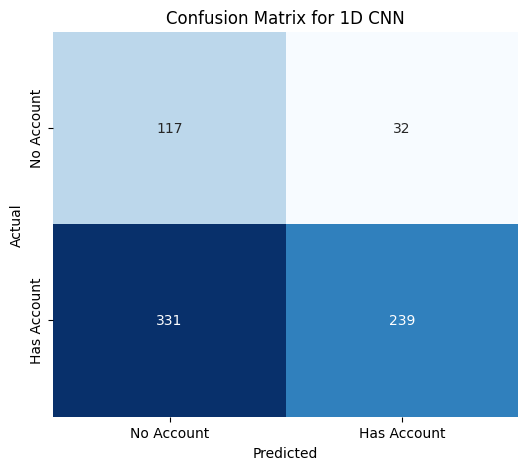

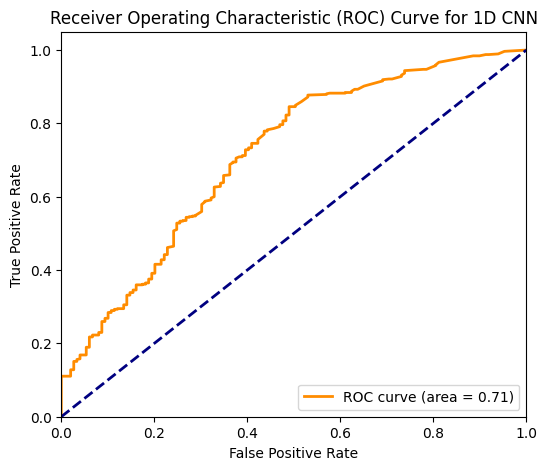

In [ ]:
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test, sample_weight=wgt_test, verbose=0)
print(f"Test Loss (1D CNN): {loss_cnn:.4f}")
print(f"Test Accuracy (1D CNN): {accuracy_cnn:.4f}")

y_pred_cnn_proba = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)

print("\nClassification Report for 1D CNN:")
print(classification_report(y_test, y_pred_cnn))

roc_auc_cnn = roc_auc_score(y_test, y_pred_cnn_proba)
print(f"ROC-AUC Score (1D CNN): {roc_auc_cnn:.4f}")

# Confusion Matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'])
plt.title('Confusion Matrix for 1D CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 1D CNN')
plt.legend(loc="lower right")
plt.show()

# Task
Prepare the scaled training and testing feature data (`X_train_scaled`, `X_test_scaled`) for an RNN model by converting any boolean columns to integers and then reshaping them into a 3D format (samples, timesteps, features), where the number of timesteps is 1 and the number of features is the number of columns in the original scaled data. This will create `X_train_rnn` and `X_test_rnn`.

In [ ]:
n_features = X_train_scaled.shape[1]

# Convert boolean columns to int before reshaping for RNN
X_train_rnn = X_train_scaled.astype(int).values.reshape(X_train_scaled.shape[0], 1, n_features)
X_test_rnn = X_test_scaled.astype(int).values.reshape(X_test_scaled.shape[0], 1, n_features)

print(f"Original X_train_scaled shape: {X_train_scaled.shape}")
print(f"Reshaped X_train_rnn shape: {X_train_rnn.shape}")
print(f"Original X_test_scaled shape: {X_test_scaled.shape}")
print(f"Reshaped X_test_rnn shape: {X_test_rnn.shape}")

Original X_train_scaled shape: (2157, 28)
Reshaped X_train_rnn shape: (2157, 1, 28)
Original X_test_scaled shape: (719, 28)
Reshaped X_test_rnn shape: (719, 1, 28)


In [ ]:
model_rnn = Sequential([
    SimpleRNN(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rnn = model_rnn.fit(
    X_train_rnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    sample_weight=combined_sample_weights,
    callbacks=[early_stopping],
    verbose=1
)

print("Simple RNN model training complete.")

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5348 - loss: 0.6676 - val_accuracy: 0.5509 - val_loss: 0.6783
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6242 - loss: 0.6212 - val_accuracy: 0.5741 - val_loss: 0.6800
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6509 - loss: 0.6050 - val_accuracy: 0.5972 - val_loss: 0.6914
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6626 - loss: 0.5911 - val_accuracy: 0.6319 - val_loss: 0.6949
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6782 - loss: 0.5879 - val_accuracy: 0.6296 - val_loss: 0.7064
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6700 - loss: 0.5957 - val_accuracy: 0.5903 - val_loss: 0.7062
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6412 - loss: 0.5873 - val_accuracy: 0.6088 - val_loss: 0.7136
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6622 - loss: 0.5738 - val_accuracy: 0.613

Test Loss (Simple RNN): 0.6850
Test Accuracy (Simple RNN): 0.5577
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report for Simple RNN:
              precision    recall  f1-score   support

           0       0.28      0.75      0.41       149
           1       0.89      0.51      0.65       570

    accuracy                           0.56       719
   macro avg       0.59      0.63      0.53       719
weighted avg       0.76      0.56      0.60       719

ROC-AUC Score (Simple RNN): 0.7039


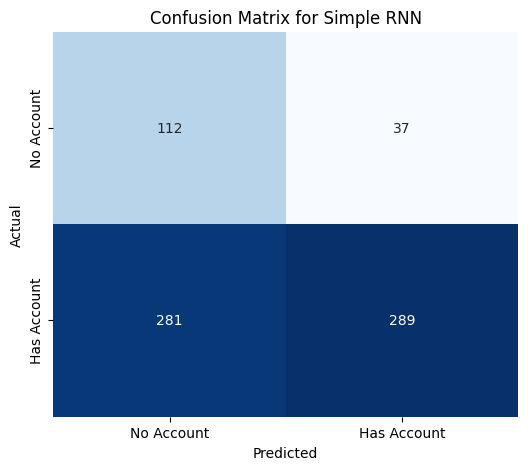

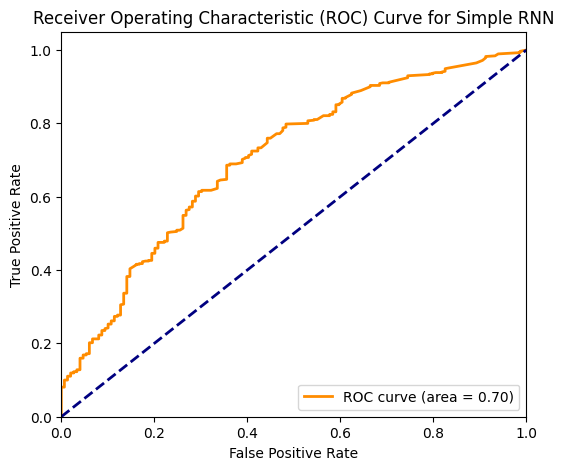

In [ ]:
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test_rnn, y_test, sample_weight=wgt_test, verbose=0)
print(f"Test Loss (Simple RNN): {loss_rnn:.4f}")
print(f"Test Accuracy (Simple RNN): {accuracy_rnn:.4f}")

y_pred_rnn_proba = model_rnn.predict(X_test_rnn)
y_pred_rnn = (y_pred_rnn_proba > 0.5).astype(int)

print("\nClassification Report for Simple RNN:")
print(classification_report(y_test, y_pred_rnn))

roc_auc_rnn = roc_auc_score(y_test, y_pred_rnn_proba)
print(f"ROC-AUC Score (Simple RNN): {roc_auc_rnn:.4f}")

# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'])
plt.title('Confusion Matrix for Simple RNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_pred_rnn_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr_rnn, tpr_rnn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rnn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Simple RNN')
plt.legend(loc="lower right")
plt.show()

# Task
```python
model_lstm = Sequential([
    LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model_lstm.summary()
```

In [ ]:
model_lstm = Sequential([
    LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,753 (354.50 KB)

 Trainable params: 90,753 (354.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = model_lstm.fit(
    X_train_rnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    sample_weight=combined_sample_weights,
    callbacks=[early_stopping],
    verbose=1
)

print("LSTM model training complete.")

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6776 - loss: 0.6658 - val_accuracy: 0.4421 - val_loss: 0.6887
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6098 - loss: 0.6418 - val_accuracy: 0.5880 - val_loss: 0.6829
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6500 - loss: 0.6054 - val_accuracy: 0.6088 - val_loss: 0.6997
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6445 - loss: 0.5953 - val_accuracy: 0.5764 - val_loss: 0.6996
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6546 - loss: 0.5820 - val_accuracy: 0.5880 - val_loss: 0.7078
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6648 - loss: 0.5863 - val_accuracy: 0.5810 - val_loss: 0.7063
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6650 - loss: 0.5843 - val_accuracy: 0.5949 - val_loss: 0.7044
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6566 - loss: 0.5730 - val_accuracy: 0.5903 - 

Test Loss (LSTM): 0.6477
Test Accuracy (LSTM): 0.6147
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.31      0.71      0.43       149
           1       0.89      0.59      0.71       570

    accuracy                           0.61       719
   macro avg       0.60      0.65      0.57       719
weighted avg       0.77      0.61      0.65       719

ROC-AUC Score (LSTM): 0.7180


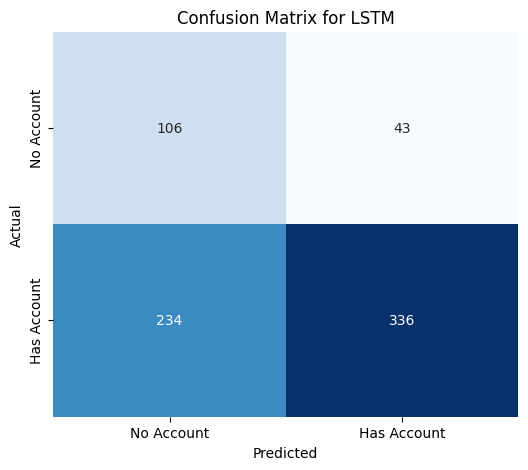

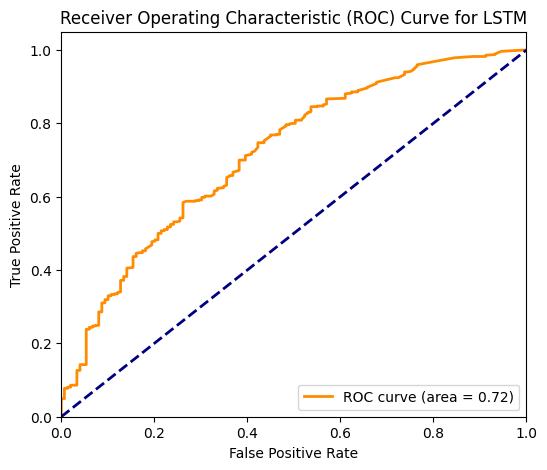

In [ ]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_rnn, y_test, sample_weight=wgt_test, verbose=0)
print(f"Test Loss (LSTM): {loss_lstm:.4f}")
print(f"Test Accuracy (LSTM): {accuracy_lstm:.4f}")

y_pred_lstm_proba = model_lstm.predict(X_test_rnn)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred_lstm))

roc_auc_lstm = roc_auc_score(y_test, y_pred_lstm_proba)
print(f"ROC-AUC Score (LSTM): {roc_auc_lstm:.4f}")

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'])
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LSTM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize a LogisticRegression model
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=51)

# 2. Train the logistic regression model using X_train_scaled, y_train, and wgt_train
log_reg_model.fit(X_train_scaled, y_train, sample_weight=wgt_train)

print("Logistic Regression model initialized and trained successfully!")

Logistic Regression model initialized and trained successfully!



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

  No account       0.35      0.82      0.49       149
have account       0.93      0.60      0.73       570

    accuracy                           0.65       719
   macro avg       0.64      0.71      0.61       719
weighted avg       0.81      0.65      0.68       719

ROC-AUC Score (Logistic Regression): 0.7788


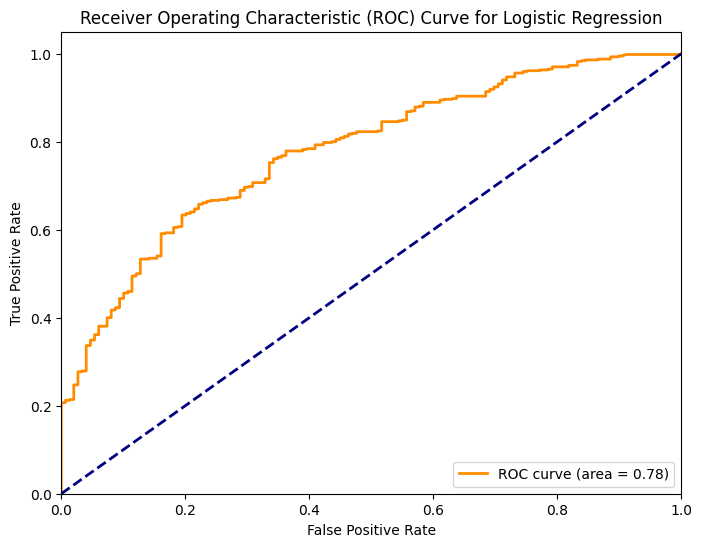

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions (probabilities) on the test set
y_pred_log_reg_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
# Make predictions (class labels) on the test set
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

# Print the Classification Report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg, target_names=["No account", "have account"])) # Added target_names for clarity

# Calculate and print the ROC-AUC Score
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg_proba)
print(f"ROC-AUC Score (Logistic Regression): {roc_auc_log_reg:.4f}")

# Plot the ROC Curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_log_reg_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()